<a href="https://colab.research.google.com/github/SAMashiyane/Residual_CNN_Explanation/blob/main/Depth_Wise_Separable_Convolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Depth-Wise Separable Convolution:** The first one applies a single 3x3 filter to each input's channels, the other applies a 1x1 filter to all the channels. If you do your match, this is the same thing as doing a normal 3x3 conv but you save parameters.

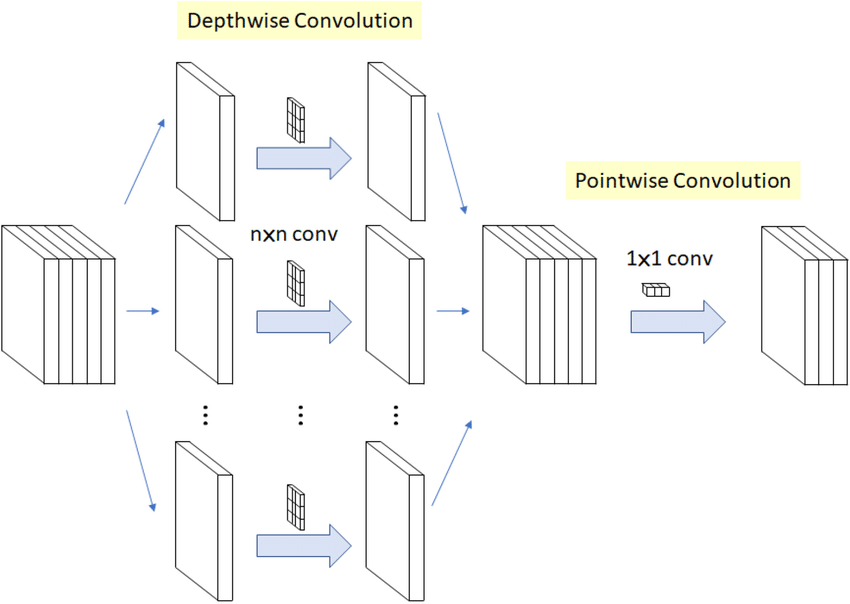

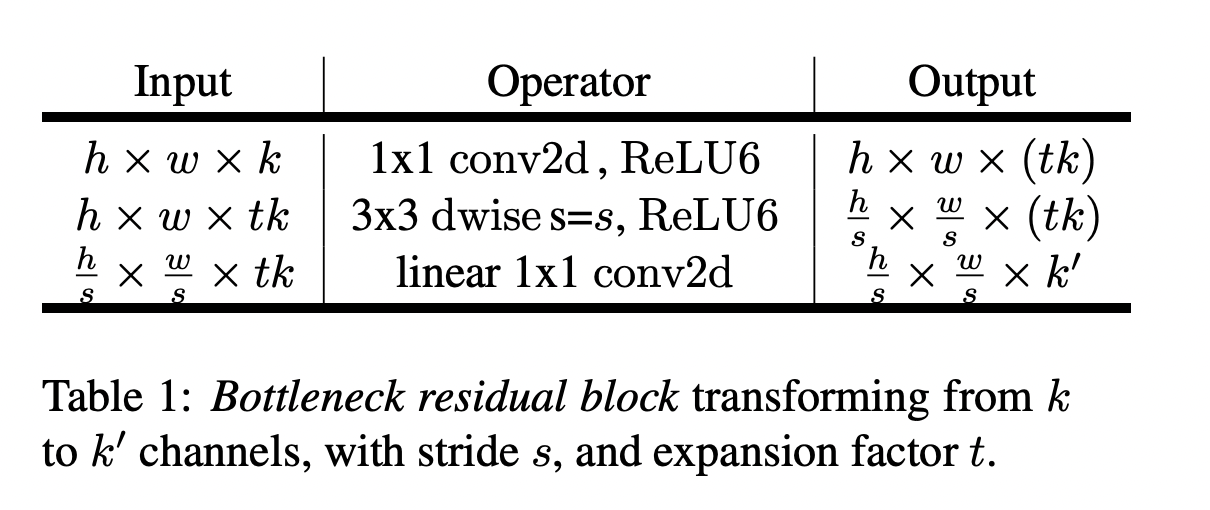

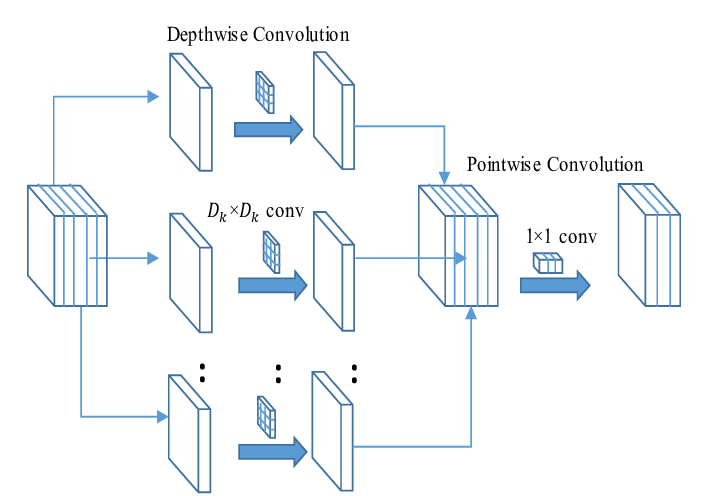

## Depth-Wise Separable Convolutions adopt a trick to splint a normal 3x3 conv in two convs to reduce the number of parameters

# **reference**:
[MobileNetV2: Inverted Residuals and Linear Bottlenecks
](https://arxiv.org/abs/1801.04381)

In [ ]:
!nvidia-smi 

Fri Apr  1 14:10:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import glob
import cv2
import shutil
from PIL import Image

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader,Dataset
from torchvision.models import resnet18, resnet34 ,resnet50
import os
import torchvision.models as models

device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
use_gpu = torch.cuda.is_available()

use_gpu

True

In [ ]:
# import torch

# x = torch.randn((1, 32, 56, 56))
# x.shape

# Conv1X1BnReLU(32, 64)(x).shape

# **groups controls the connections between inputs and outputs. in_channels and out_channels must both be divisible by groups**
*int_channels/groups = integer & out_channels/groups = integer*

For example,

**At groups=1**, all inputs are convolved to all outputs.

**At groups=2**, the operation becomes equivalent to having two conv layers side by side, each seeing half the input channels and producing half the output channels, and both subsequently concatenated.

**At groups= in_channels**, each input channel is convolved with its own set of filters of size .

# ​**num_kernel_channels_per_input_channels == groups**

## **input_channels/num_kernel_channels = groups** 

In [ ]:
# W = 32 ---> 
# nn.conv2d --> There is a function to create a filter with random weight according to the available data.
#T he output we receive from the Conv2d is always a tensor (Includes weight and ..)
kernel = torch.nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3), groups=1) # -------> W-F+2p/s +1  ==> 32-3/1 +1 = 30
kernel.weight.shape
# kernel.bias.shape
#paremeters in conv2d includes     weight  and     bias 
[p.shape for p in kernel.parameters()]
# for p in kernel.parameters():
#    print(p)


[torch.Size([8, 4, 3, 3]), torch.Size([8])]

In [ ]:
x = torch.randn((1,4, 32, 32)) 
y = kernel(x)
y.shape

torch.Size([1, 8, 30, 30])

In [ ]:
kernel = torch.nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3), groups=1)# in_channels/groups = num_kernel_channels ==> 4/1 = 4
kernel

Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))

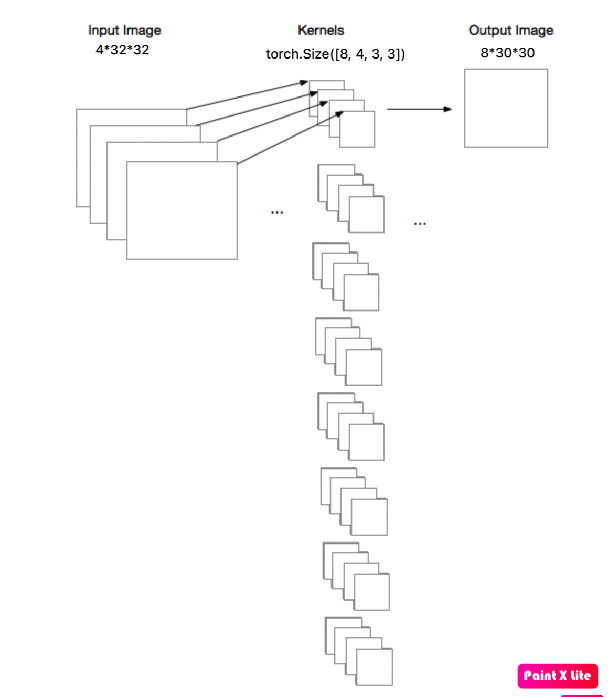

In [ ]:
kernel =nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3), groups=2) # in_channels/groups = num_kernel_channels ==> 4/2 = 2
kernel.weight.shape


torch.Size([8, 2, 3, 3])

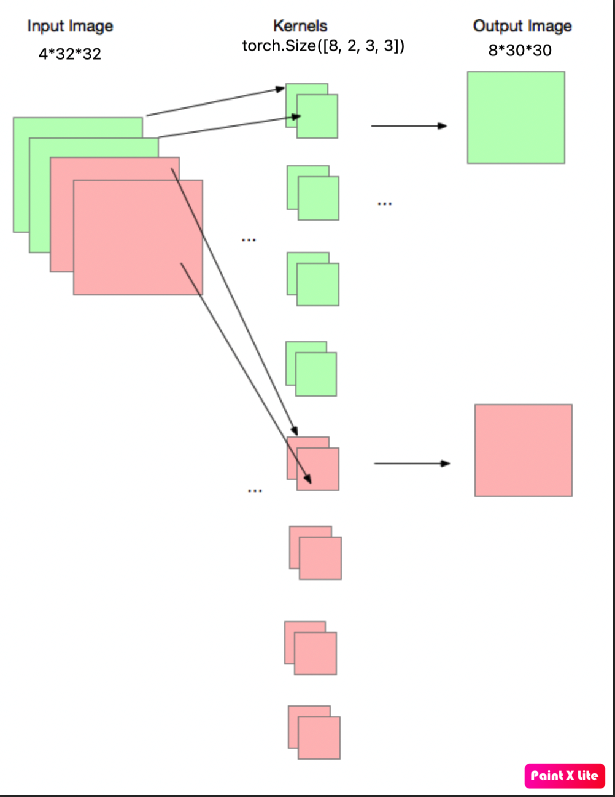

In [ ]:
kernel =nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3), groups=4)
kernel.weight.shape

torch.Size([8, 1, 3, 3])

In [ ]:
kernel =nn.Conv2d(in_channels=4, out_channels=4, kernel_size=(3, 3), groups=4)
kernel.weight.shape

torch.Size([4, 1, 3, 3])

In [ ]:
kernel = torch.nn.Conv2d(3, 9, (3, 3), groups=3) # in_channels/groups = num_kernel_channels ==> 3/3 = 1
kernel.weight.shape

torch.Size([9, 1, 3, 3])

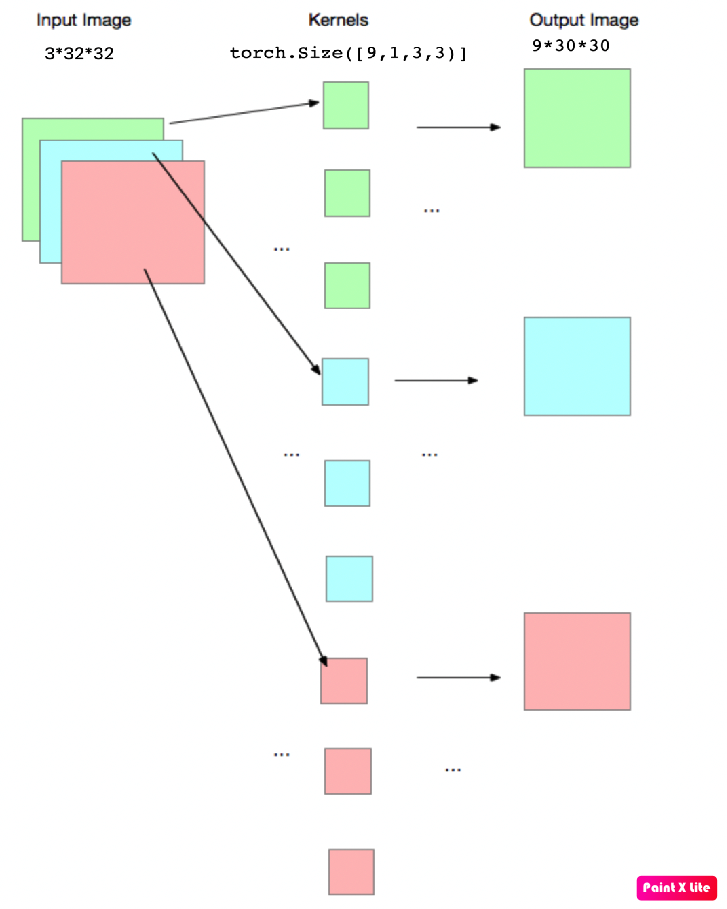

**We used the groups property  in pytorch(see before notebooks:) to create depth-wise-separable Convolution** 

In [ ]:
# dwise_conv.  --->    Depth-wise-separable Convolution 
def dwise_conv(ch_in):
    return (
        nn.Sequential(
            #depthwise
            nn.Conv2d(ch_in, ch_in, kernel_size=3, padding=1, stride=1, groups=ch_in, bias=False), #  
            nn.BatchNorm2d(ch_in), # 
            nn.ReLU6(inplace=True),
        )
    )

Image shape before: torch.Size([3, 224, 224])
Image shape after add dim: torch.Size([1, 3, 224, 224])


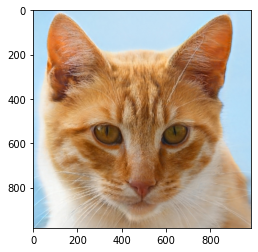

In [ ]:
img_BNeck = Image.open(str('/content/sample_data/cat.jpeg'))
plt.imshow(img_BNeck)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0., std=1.)
])
img_BNeck = transform(img_BNeck)
print(f"Image shape before: {img_BNeck.shape}")
img_BNeck = img_BNeck.unsqueeze(0)
print(f"Image shape after add dim: {img_BNeck.shape}")
img_BNeck = img_BNeck.to(device)


In [ ]:
dw = dwise_conv(3) # ---> int_chanals = 3
dw.to(device)
dw(img_BNeck).shape

torch.Size([1, 3, 224, 224])

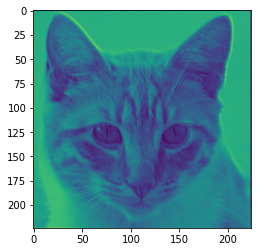

In [ ]:

ir = dw(img_BNeck)
shortcut_image = ir.squeeze(0)
shortcut_image.shape 
shortcut_image  = torch.sum(shortcut_image/3,0)# decrease by sum dim
shortcut_image  = shortcut_image.data.cpu().numpy()
shortcut_image.shape #---> (224, 224)
plt.imshow(shortcut_image)

In [ ]:
import torch.nn as nn
from torchsummary import summary

def dwise_conv(ch_in, stride=1):
    return (
        nn.Sequential(
            #depthwise
            nn.Conv2d(ch_in, ch_in, kernel_size=3, padding=1, stride=stride, groups=ch_in, bias=False),
            nn.BatchNorm2d(ch_in),
            nn.ReLU6(inplace=True),
        )
    )

def conv1x1(ch_in, ch_out):
    return (
        nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=1, padding=0, stride=1, bias=False),
            nn.BatchNorm2d(ch_out),
            nn.ReLU6(inplace=True)
        )
    )

def conv3x3(ch_in, ch_out, stride):
    return (
        nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3, padding=1, stride=stride, bias=False),
            nn.BatchNorm2d(ch_out),
            nn.ReLU6(inplace=True)
        )
    )

class InvertedBlock(nn.Module):
    def __init__(self, ch_in, ch_out, expand_ratio, stride):
        super(InvertedBlock, self).__init__()

        self.stride = stride
        assert stride in [1,2]

        hidden_dim = ch_in * expand_ratio

        self.use_res_connect = self.stride ==1 and ch_in == ch_out

        layers = []
        if expand_ratio != 1:
            layers.append(conv1x1(ch_in, hidden_dim))
        layers.extend([
            #dw
            dwise_conv(hidden_dim, stride=stride),
            #pw
            conv1x1(hidden_dim, ch_out)
        ])

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.layers(x)
        else:
            return self.layers(x)

In [ ]:
from typing import Optional
from functools import partial
class ConvNormAct(nn.Sequential):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        kernel_size: int,
        norm: nn.Module = nn.BatchNorm2d,
        act: nn.Module = nn.ReLU,
        **kwargs
    ):

        super().__init__(
            nn.Conv2d(
                in_features,
                out_features,
                kernel_size=kernel_size,
                padding=kernel_size // 2,
            ),
            norm(out_features),
            act(),
        )
# --------------------------------------------------------------------
Conv1X1BnReLU = partial(ConvNormAct, kernel_size=1)
Conv3X3BnReLU = partial(ConvNormAct, kernel_size=3)
# ---------------------------------------------------------------------
class ResidualAdd(nn.Module):
    def __init__(self, block: nn.Module, shortcut: Optional[nn.Module] = None):
        super().__init__()
        self.block = block
        self.shortcut = shortcut
        
    def forward(self,x):
        res = x
        x = self.block(x)
        if self.shortcut:
            res = self.shortcut(res)
        x += res
        return x

class InvertedResidual(nn.Sequential):
    def __init__(self, in_features: int, out_features: int, expansion: int = 4):
        expanded_features = in_features * expansion
        super().__init__(
            nn.Sequential(
                ResidualAdd(
                    nn.Sequential(
                        # narrow -> wide
                        Conv1X1BnReLU(in_features, expanded_features),
                        # wide -> wide
                        Conv3X3BnReLU(expanded_features, expanded_features),
                        # wide -> narrow
                        Conv1X1BnReLU(expanded_features, out_features, act=nn.Identity),
                    ),
                    shortcut=Conv1X1BnReLU(in_features, out_features)
                    if in_features != out_features
                    else None,
                ),
                nn.ReLU(),
            )
        )
        

In [ ]:
a = InvertedBlock(3,3,4,1)
a

InvertedBlock(
  (layers): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 12, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=12, bias=False)
      (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(12, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
  )
)

In [ ]:
b = InvertedResidual(3,6,4)
b

InvertedResidual(
  (0): Sequential(
    (0): ResidualAdd(
      (block): Sequential(
        (0): ConvNormAct(
          (0): Conv2d(3, 12, kernel_size=(1, 1), stride=(1, 1))
          (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (1): ConvNormAct(
          (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (2): ConvNormAct(
          (0): Conv2d(12, 6, kernel_size=(1, 1), stride=(1, 1))
          (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Identity()
        )
      )
      (shortcut): ConvNormAct(
        (0): Conv2d(3, 6, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (1): ReLU()
 

In [ ]:
class MobileNetLikeBlock(nn.Sequential):
    def __init__(self, in_features: int, out_features: int, expansion: int = 4):
        # use ResidualAdd if features match, otherwise a normal Sequential
        residual = ResidualAdd if in_features == out_features else nn.Sequential
        expanded_features = in_features * expansion
        super().__init__(
            nn.Sequential(
                residual(
                    nn.Sequential(
                        # narrow -> wide
                        Conv1X1BnReLU(in_features, expanded_features),
                        # wide -> wide
                        Conv3X3BnReLU(expanded_features, expanded_features),
                        # wide -> narrow
                        Conv1X1BnReLU(expanded_features, out_features, act=nn.Identity),
                    ),
                ),
                nn.ReLU(),
            )
        )

This notebook continues ...